In [1]:
# Load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the forest fire dataset from UCI Machine Learning Repository
forest_data = pd.read_csv('forestfires.csv')

## 1. Summary Statistics

In [3]:
# Summary statistics of each variable
forest_data.describe()

X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655818  
min      2.200000   15.000000    0.400000    0.000000     0.000000  
25%     15.500000   33.000000    2.700000    0.000000     0.000000  
50%     19.300000   42.000000    4.000000    0.000000     0.520000  
75%     22.800000   53.000000    4.900000    0.000000     6.570000  
max     33.300000  100.000000    9.400000    6.400000  1090.840000

In [30]:
# Number of missing values for each variable
forest_data.isnull().sum(axis = 0)

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

**Observation**: 

If we look closely to the target variable, `area`, we can notice that the maximum value is way larger than the 75-percentile. It may indicate possible extreme value/outlier.

Largest top 10 values for the `area` variable: `[105.66, 154.88, 174.63, 185.76, 196.48, 200.94, 212.88, 278.53, 746.28, 1090.84]`

After a closer look, we do see two records with extremely large values compared to others, `746.28` and `1090.84`. Hence, we exclude those two records in the following explorative data analysis. These records should be treated separately in any future potential modeling process.

In [55]:
forest_data_sub = forest_data.loc[forest_data.area < 300,:]

## 2. Correlation Heat Map

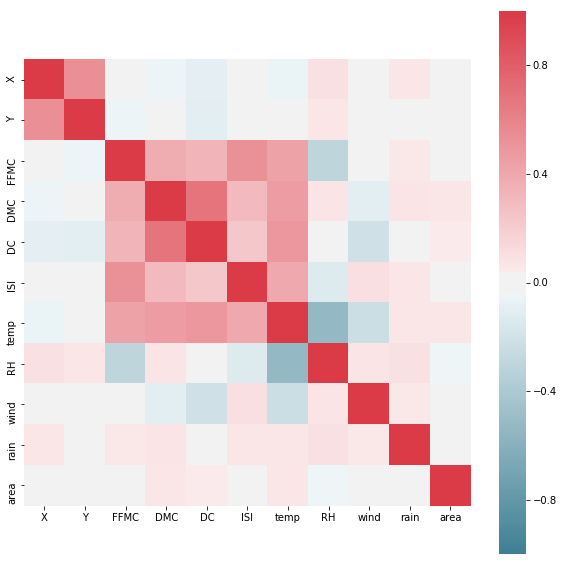

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax = sns.heatmap(forest_data_sub.corr(), vmin = -1, vmax = 1, square = True, cmap = sns.diverging_palette(220, 10, as_cmap=True))

In [3]:
def high_corr(corr_matrix, threshold = 0.8):
    # Get the magnitude of correlation
    abs_corr = corr_matrix.abs()
    # Select upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find the index of feature columns with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    return to_drop

In [8]:
np.triu(np.ones(forest_data.corr().shape), k=1)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
high_corr(forest_data.corr(), threshold=0.3)

['Y', 'DMC', 'DC', 'ISI', 'temp']

**Observation**:

1. All index values from the FWI (Fire Weather Index) system have strong correlation with each other, which makes sense since all of them are trying to measure the same object.
2. `temp` and `RH (relative humidity)` has a negative correlation which is also align with our commen sense.
3. Our main target, `area`, does not seem to have any directly clear correlation with any other variables in this dataset.

## 3. Pairwise plots

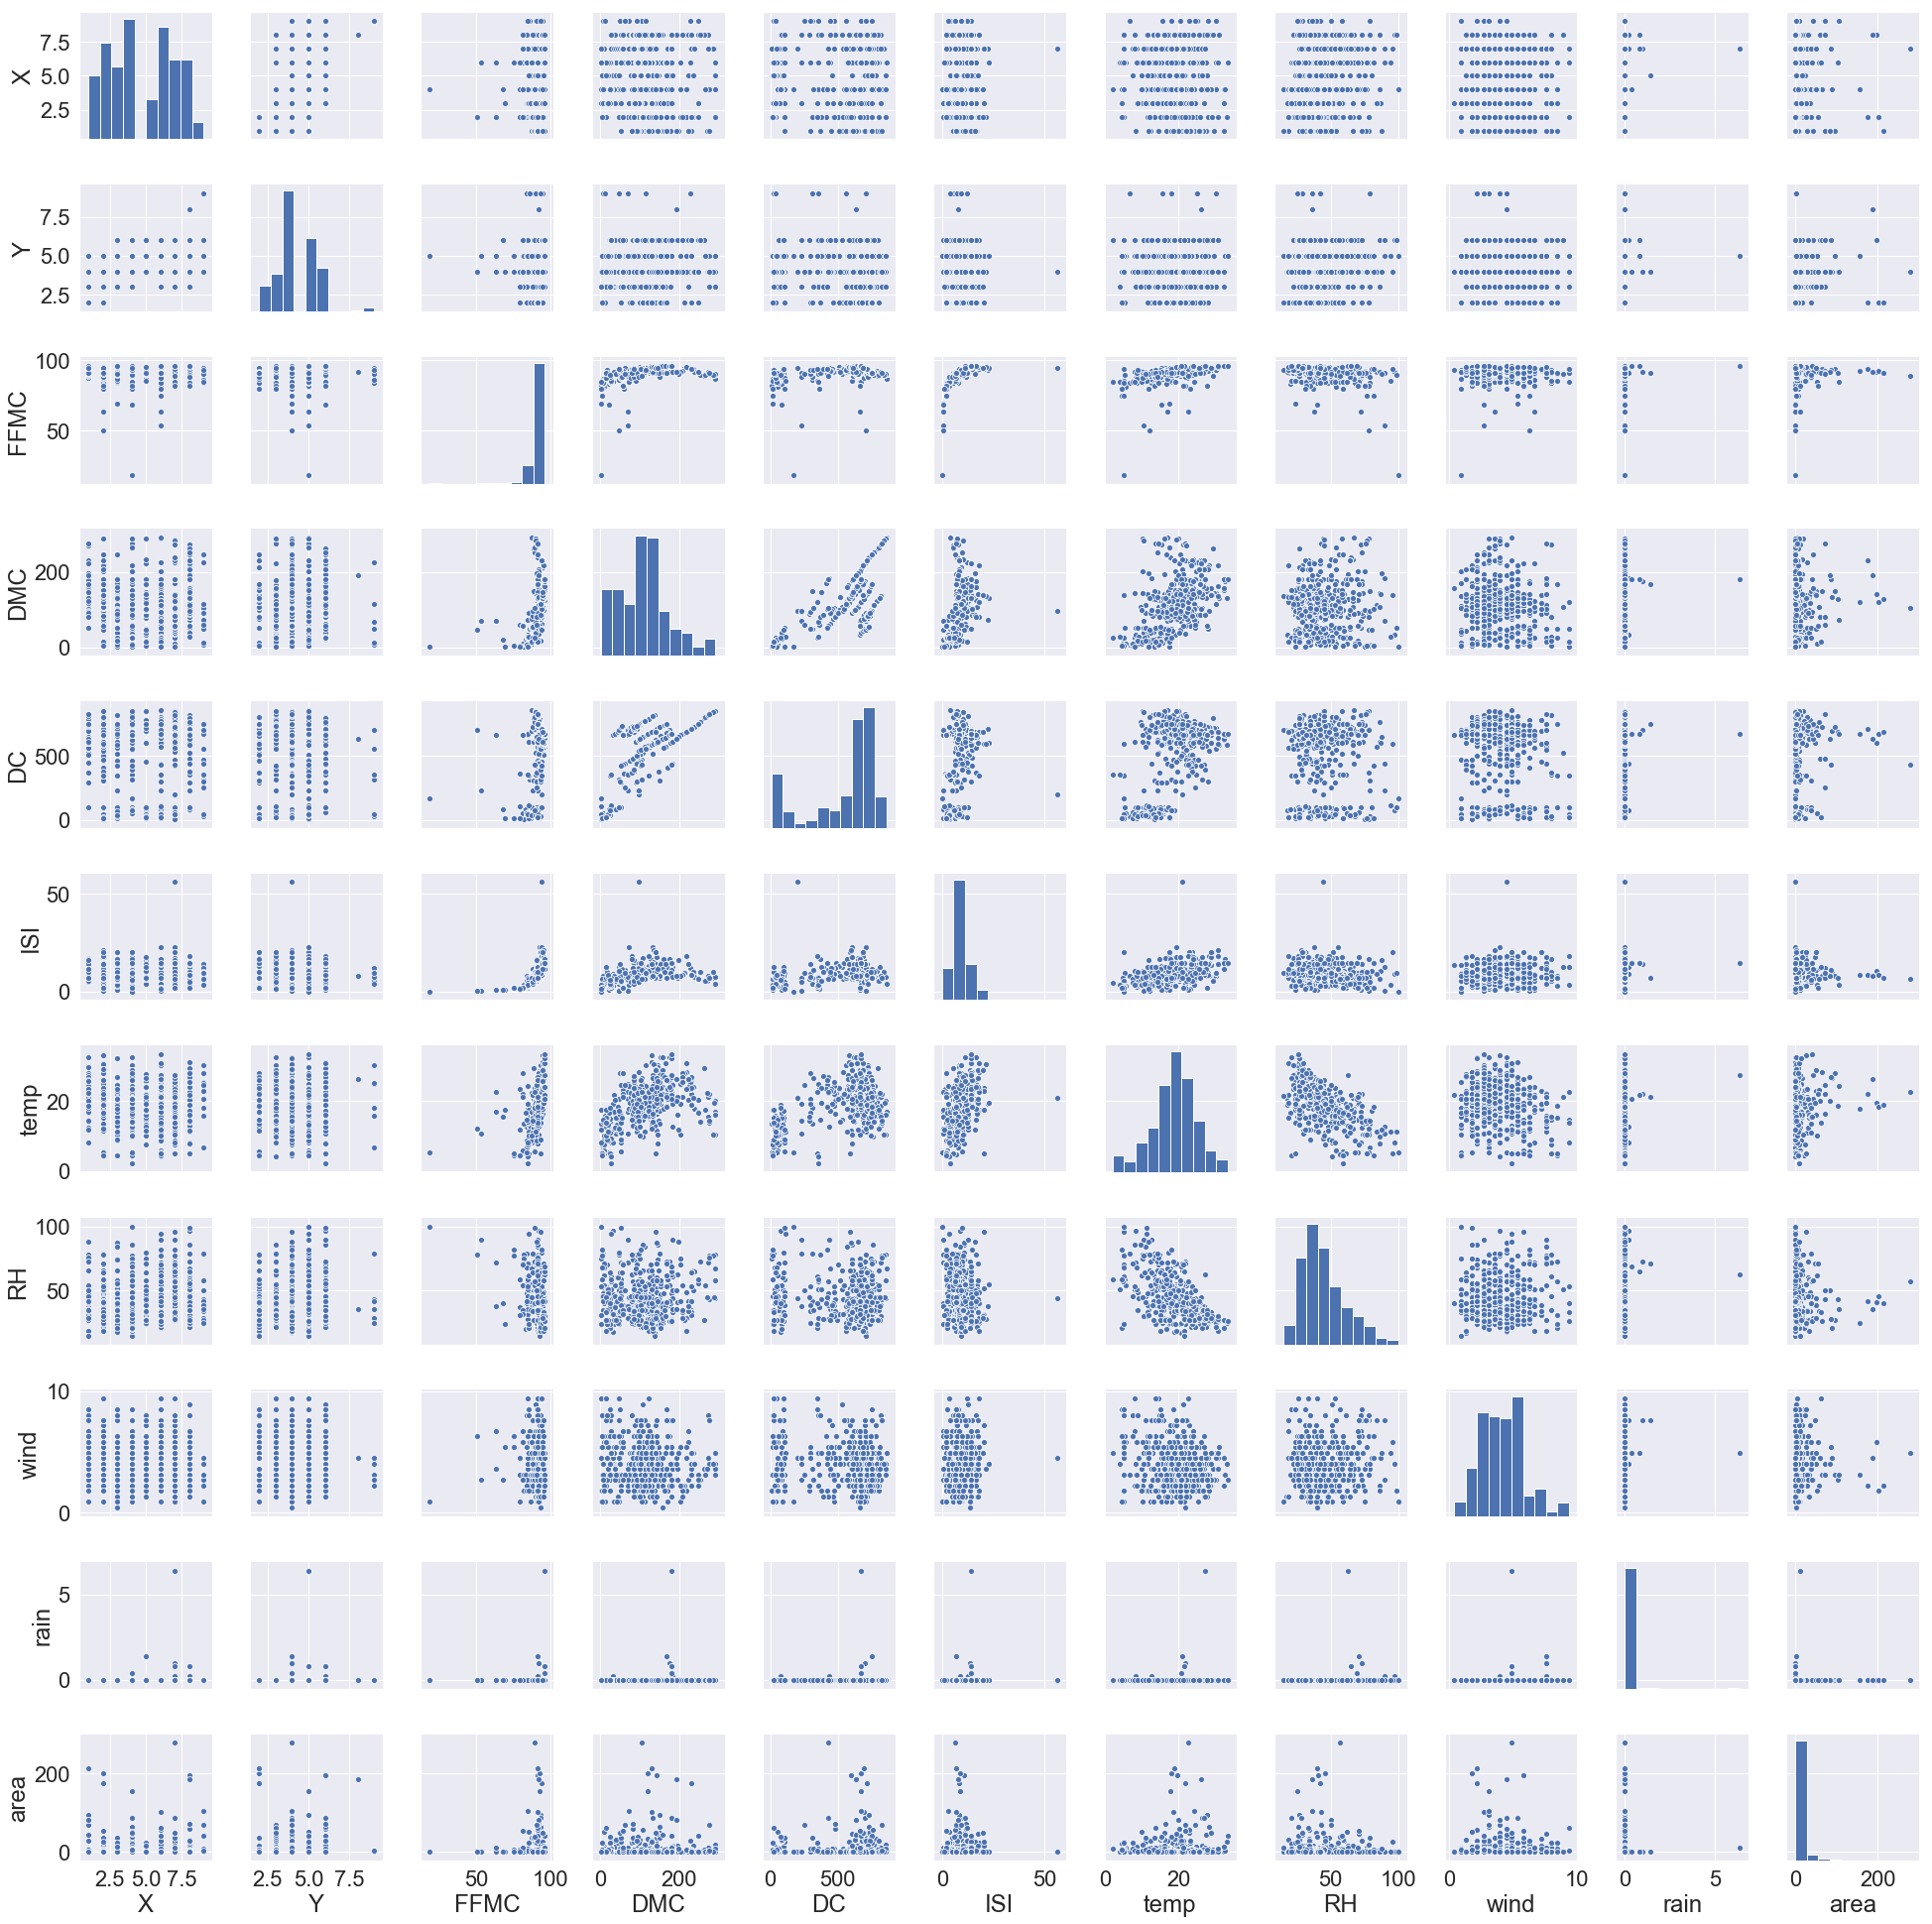

In [84]:
sns.set(font_scale=2)
ax = sns.pairplot(forest_data_sub)

In [79]:
# Number of unique coordinates
len(np.unique([[x,y] for x,y in zip(forest_data_sub.X,forest_data_sub.Y)], axis = 0))

36

In [82]:
# Number of the events with zero burned area
print('{} records ({:.2f}%) have zero burned area'.format(sum(forest_data_sub.area == 0), 
                                                      100 * sum(forest_data_sub.area == 0)/forest_data_sub.shape[0]))

247 records (47.96%) have zero burned area


**Observation**:
    
1. Although we have `517` different forest fire events recorded, they only happen in `36` different locations
2. Most of the events happen with zero or very little raining
3. Nearly half (`47.96%`) of the events have zero burned area, which should be considered when try to model the target variable